# Practice for 5511 RNN 
### Natural Language Processing with Disaster Tweets


*May 2023*


### **Problem Statement**

The main objective of this project is to develop a RNN model that can classify which Tweets are about real disasters and which ones are not. 



### **Data Source:**

https://www.kaggle.com/competitions/nlp-getting-started/data


The data set includes 7613 Tweets for training, each text has a label of 0 or 1 in 'train.csv', and also 3263 test Tweets to be labeled.




### **Methodology**

To classify test text with the right label, we will use rnn. After implementing this approach, we will upload the label of test Tweets to kaggle to see the accuracy.

By completing this project, we hope to enhance our knowledge of RNN and its applicability in real-world scenarios.


### **Detail steps** 


**1. Exploratory Data Analysis (EDA)** 

Firstly we will explore and visualize the data to understand the structure and distribution of the data.  

**2. Model Training & Evaluation**

Next, we will build rnn with training data set and check the performance on test dataset. 
We need sequential model to process sequence of text data. 
Architectures with LSTM and GRU will be tried.

**3. Conclusions**

Finally, we will summarize the results and see what can be improved in the future. 

In [78]:
# importing the necessary libraries:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import re

import nltk # To work with natural language
from nltk.tokenize import word_tokenize # To tokenize each tweet
from nltk.corpus import PlaintextCorpusReader # To create the corpus

import regex as re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,GRU,Dense,SpatialDropout1D,Dropout,Flatten
from keras.initializers import Constant
from keras.optimizers import Adam

from keras.callbacks import LearningRateScheduler
import math
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

import warnings

# Define the filter to ignore the MarkupResemblesLocatorWarning
warnings.filterwarnings("ignore", category=UserWarning, message="MarkupResemblesLocatorWarning")

#  EDA

### DATA LOADING

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### DATA DISTRIBUTION

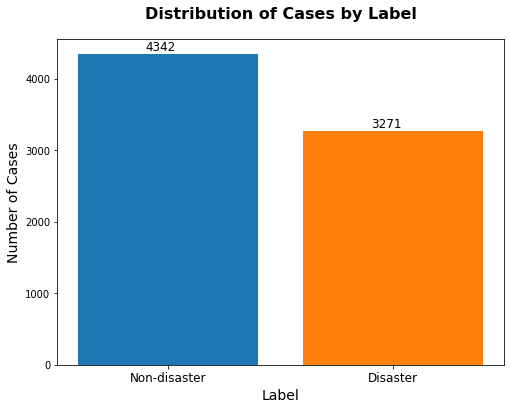

In [6]:
# Count the cases by label
cases_by_label = df_train['target'].value_counts()

plt.figure(figsize=(8,6)) # Set the figure size
plt.bar(cases_by_label.index, cases_by_label.values, color=['tab:blue', 'tab:orange'])
plt.title('Distribution of Cases by Label', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.xticks(cases_by_label.index, ['Non-disaster', 'Disaster'], fontsize=12)

for i, v in enumerate(cases_by_label.values):
    plt.text(i-0.1, v+50, str(v), color='black', fontsize=12)

plt.show()

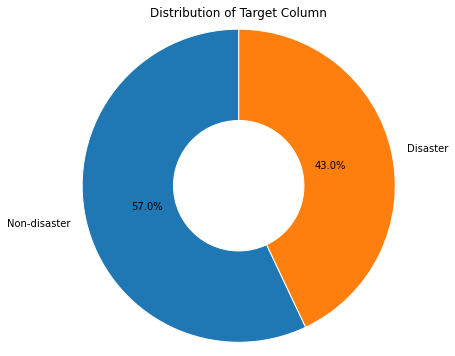

In [7]:
# Plot the donut chart

fig, ax = plt.subplots(figsize=(8,6))

# Draw a circle
centre_circle = plt.Circle((0,0),0.3,fc='white',linewidth=1)
fig.gca().add_artist(centre_circle)

# Plot the donut chart
ax.pie(cases_by_label, labels=['Non-disaster', 'Disaster'], autopct='%1.1f%%', startangle=90, radius=1.2,
       wedgeprops=dict(width=0.7, edgecolor='w'))

plt.title('Distribution of Target Column')

plt.show()

In [8]:
# summarize numeric columns
df_train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [9]:
# summarize text columns
df_train.describe(include=['object'])

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


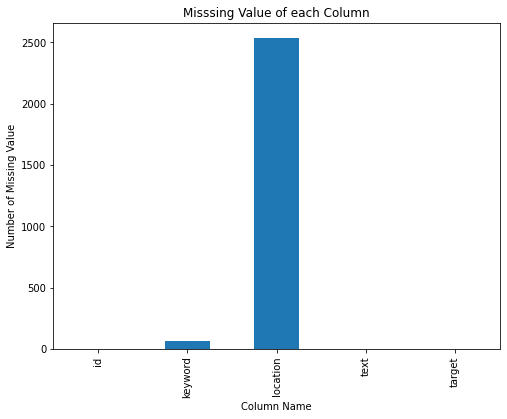

In [10]:
# Check Misssing value
null_vals = df_train.isnull().sum()
print(null_vals)
plt.figure(figsize=(8,6)) # Set the figure size

# Call plot.bar() method to create the bar plot
null_vals.plot.bar()

# Set the title of the plot
plt.title("Misssing Value of each Column")

# Add x and y axis labels
plt.xlabel("Column Name")
plt.ylabel("Number of Missing Value")

# Display the plot
plt.show()

## Observations:

* There are 2533 missing labels in location column and 63 missing values in keyword
* In the training dataset, the ratio of positive cases to negative cases is 43:57, it's quite balanced, so we don't need to take additional actions to balance the data.

### DATA CLEANING



In [80]:
warnings.filterwarnings("ignore", category=UserWarning)
# download stopwords dictionary
# nltk.download('stopwords')

# create a set of stopwords
stop_words = set(stopwords.words('english'))


# define function to clean tweets
def clean_tweet(text):
    # remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    
    # remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # remove urls
    text = re.sub(r"http\S+", "", text)

    # remove <> tags
    text = re.sub(r"</?[a-z]+>", "", text)

    # convert text to lowercase
    text = text.lower()

    # remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

# apply the function to the 'text' column and save the cleaned text in 'text_new' column
df_train['text_new'] = df_train['text'].apply(clean_tweet)


In [84]:
# Check cleaning result
pd.set_option('display.max_colwidth', None)
print(df_train.loc[40, ['text', 'text_new']])

text        Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw
text_new                                                                                                      check out: #nsfw
Name: 40, dtype: object


## DATA PROCESSING

### Word corpus and Embedding Dictionary

In [13]:
# Create Words Tokens

# Tokenize the tweets in the 'text_new' column and save them as a list of lists
def create_tokens(dataset):
    
    tmp_tokens =[]

    for sentence in tqdm(dataset['text_new']):
        words = [ word.lower() for word in word_tokenize(sentence) if (word.isalpha() == 1 ) & (word not in stop_words) ]
        tmp_tokens.append(words)
    
    return tmp_tokens
    

tokens = create_tokens(df_train)

100%|████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:01<00:00, 5449.55it/s]


In [14]:
tokens[0]

['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

In [15]:
print(df_train.iloc[0])

id                                                                              1
keyword                                                                       NaN
location                                                                      NaN
text        Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
target                                                                          1
text_new                            deeds reason #earthquake may allah forgive us
Name: 0, dtype: object


In [16]:
# Create Embedding Dictionary

embedding_dict={}
with open('./data/glove.twitter.27B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [17]:
# Tokenize : break the sentence into single word/token
# texts_to_sequences : convert tokenized word into an encoded sequnce
# pad_sequence : change the length of sequence by either adding or truncating

MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)

sequences = tokenizer.texts_to_sequences(tokens)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [18]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 14927


In [19]:
corpus_pad.shape

(7613, 20)

In [20]:
corpus_pad

array([[4063,  673,  152, ...,    0,    0,    0],
       [  92,    2,  126, ...,    0,    0,    0],
       [1490, 1372,  515, ...,    0,    0,    0],
       ...,
       [1360,  454, 1361, ...,    0,    0,    0],
       [  12,  932,  210, ...,    0,    0,    0],
       [ 108,  102,  403, ...,    0,    0,    0]])

In [21]:
sequences[0]

[4063, 673, 152, 53, 1371, 4064, 17]

In [22]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████| 14927/14927 [00:00<00:00, 353981.62it/s]


# MODELING AND EVALUATION

**In this work we will practice 2 kinds of recurrent neural networks (RNNs)**
**and see which algorithm has higher accuracy**

* LSTM (Long Short-Term Memory)
* GRU (Gated Recurrent Unit)


## Build Model: LSTM

In [23]:
# Long Short Term Memory network.

# We need sequential model to process sequence of text data
model=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model.add(embedding)

# Drops 40% of entire row
model.add(SpatialDropout1D(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           1492800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 1,535,105
Trainable params: 42,305
Non-trainable params: 1,492,800
_________________________________________________________________


In [24]:
X_train,X_test,y_train,y_test = train_test_split(corpus_pad, df_train['target'].values, test_size = 0.25, random_state = 0 )

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

print('Shape of train',y_train.shape)
print("Shape of Validation ",y_test.shape)

Shape of train (5709, 20)
Shape of Validation  (1904, 20)
Shape of train (5709,)
Shape of Validation  (1904,)


In [25]:
history=model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2)

Epoch 1/30
179/179 - 6s - loss: 0.6723 - accuracy: 0.6421 - val_loss: 0.5786 - val_accuracy: 0.7647 - 6s/epoch - 35ms/step
Epoch 2/30
179/179 - 3s - loss: 0.5276 - accuracy: 0.7541 - val_loss: 0.4815 - val_accuracy: 0.7778 - 3s/epoch - 15ms/step
Epoch 3/30
179/179 - 3s - loss: 0.4880 - accuracy: 0.7770 - val_loss: 0.4811 - val_accuracy: 0.7862 - 3s/epoch - 15ms/step
Epoch 4/30
179/179 - 3s - loss: 0.4757 - accuracy: 0.7831 - val_loss: 0.4706 - val_accuracy: 0.7941 - 3s/epoch - 15ms/step
Epoch 5/30
179/179 - 3s - loss: 0.4774 - accuracy: 0.7819 - val_loss: 0.4660 - val_accuracy: 0.7931 - 3s/epoch - 15ms/step
Epoch 6/30
179/179 - 3s - loss: 0.4748 - accuracy: 0.7831 - val_loss: 0.4577 - val_accuracy: 0.7962 - 3s/epoch - 15ms/step
Epoch 7/30
179/179 - 3s - loss: 0.4715 - accuracy: 0.7867 - val_loss: 0.4621 - val_accuracy: 0.7973 - 3s/epoch - 15ms/step
Epoch 8/30
179/179 - 3s - loss: 0.4690 - accuracy: 0.7860 - val_loss: 0.4620 - val_accuracy: 0.7967 - 3s/epoch - 16ms/step
Epoch 9/30
179/1

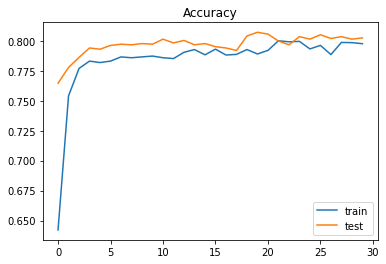

In [26]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

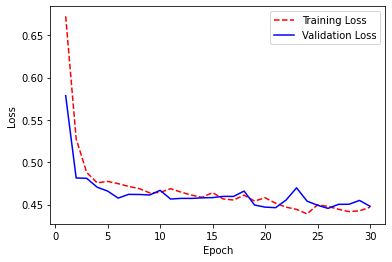

In [27]:
# Loss vs Epoch
# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.

epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Prediction

In [85]:
# Clean Test data


# apply the clean_tweet function to the 'text' column and save the cleaned text in 'text_new' column
df_test['text_new'] = df_test['text'].apply(clean_tweet)



In [29]:
# Creating test tokens

test_tokens = create_tokens(df_test)


100%|████████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 5450.74it/s]


In [30]:
# Encoding Test Text to Sequences
test_sequences = tokenizer.texts_to_sequences(test_tokens)

test_corpus_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [31]:
# Predictions
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)

102/102 [==============================] - 1s 3ms/step


In [32]:
# Creating submission file 
submission = pd.DataFrame({'id' : df_test['id'], 'target' : predictions})
submission.to_csv('./data/submission.csv', index=False)

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Build Model: GRU

In [33]:
# Try GRU

# We need sequential model_gru to process sequence of text data
model_gru=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model_gru.add(embedding)

# Drops 40% of entire row
model_gru.add(SpatialDropout1D(0.4))

# Recurrent Layer GRU(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model_gru.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model_gru.add(Dense(1, activation='sigmoid'))

# Compile the model_gru compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model_gru.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           1492800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 20, 100)          0         
 lDropout1D)                                                     
                                                                 
 gru (GRU)                   (None, 64)                31872     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,524,737
Trainable params: 31,937
Non-trainable params: 1,492,800
_________________________________________________________________


In [34]:
history=model_gru.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2)

Epoch 1/30
179/179 - 6s - loss: 0.6885 - accuracy: 0.5652 - val_loss: 0.6819 - val_accuracy: 0.5825 - 6s/epoch - 32ms/step
Epoch 2/30
179/179 - 2s - loss: 0.6516 - accuracy: 0.6124 - val_loss: 0.5203 - val_accuracy: 0.7537 - 2s/epoch - 13ms/step
Epoch 3/30
179/179 - 2s - loss: 0.5077 - accuracy: 0.7646 - val_loss: 0.4850 - val_accuracy: 0.7857 - 2s/epoch - 13ms/step
Epoch 4/30
179/179 - 2s - loss: 0.4889 - accuracy: 0.7732 - val_loss: 0.4781 - val_accuracy: 0.7904 - 2s/epoch - 13ms/step
Epoch 5/30
179/179 - 2s - loss: 0.4882 - accuracy: 0.7683 - val_loss: 0.4657 - val_accuracy: 0.7925 - 2s/epoch - 13ms/step
Epoch 6/30
179/179 - 2s - loss: 0.4830 - accuracy: 0.7756 - val_loss: 0.4737 - val_accuracy: 0.7910 - 2s/epoch - 13ms/step
Epoch 7/30
179/179 - 2s - loss: 0.4803 - accuracy: 0.7791 - val_loss: 0.4630 - val_accuracy: 0.7910 - 2s/epoch - 14ms/step
Epoch 8/30
179/179 - 3s - loss: 0.4787 - accuracy: 0.7784 - val_loss: 0.4642 - val_accuracy: 0.7915 - 3s/epoch - 15ms/step
Epoch 9/30
179/1

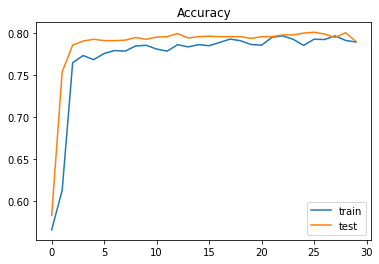

In [35]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [36]:
# Predictions
predictions = model_gru.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)
# Creating submission file 
submission = pd.DataFrame({'id' : df_test['id'], 'target' : predictions})
submission.to_csv('./data/gru_submission.csv', index=False)

submission.head()

102/102 [==============================] - 1s 3ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Try LSTM with learning rate scheduling

After submitting the preiction to Kaggle, the result with LSTM is slightly higher than GRU.
Let's stick to LSTM and see if we can further improve the performance with learning rate scheduling

In [41]:
# Long Short Term Memory network.

# We need sequential model to process sequence of text data
model=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model.add(embedding)

# Drops 40% of entire row
model.add(SpatialDropout1D(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           1492800   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 20, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,535,105
Trainable params: 42,305
Non-trainable params: 1,492,800
_________________________________________________________________


In [42]:
# Define learning rate schedule
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lrate = LearningRateScheduler(step_decay)

# train model with learning rate schedule
history=model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2,callbacks=[lrate])

Epoch 1/30
179/179 - 7s - loss: 0.5344 - accuracy: 0.7514 - val_loss: 0.4657 - val_accuracy: 0.7946 - lr: 0.0100 - 7s/epoch - 41ms/step
Epoch 2/30
179/179 - 3s - loss: 0.4800 - accuracy: 0.7842 - val_loss: 0.4706 - val_accuracy: 0.7768 - lr: 0.0100 - 3s/epoch - 16ms/step
Epoch 3/30
179/179 - 3s - loss: 0.4643 - accuracy: 0.7868 - val_loss: 0.4472 - val_accuracy: 0.7941 - lr: 0.0100 - 3s/epoch - 16ms/step
Epoch 4/30
179/179 - 3s - loss: 0.4488 - accuracy: 0.8019 - val_loss: 0.4513 - val_accuracy: 0.8083 - lr: 0.0100 - 3s/epoch - 16ms/step
Epoch 5/30
179/179 - 3s - loss: 0.4396 - accuracy: 0.7994 - val_loss: 0.4388 - val_accuracy: 0.8067 - lr: 0.0050 - 3s/epoch - 16ms/step
Epoch 6/30
179/179 - 3s - loss: 0.4266 - accuracy: 0.8084 - val_loss: 0.4479 - val_accuracy: 0.8009 - lr: 0.0050 - 3s/epoch - 16ms/step
Epoch 7/30
179/179 - 3s - loss: 0.4165 - accuracy: 0.8163 - val_loss: 0.4573 - val_accuracy: 0.8030 - lr: 0.0050 - 3s/epoch - 16ms/step
Epoch 8/30
179/179 - 3s - loss: 0.4210 - accurac

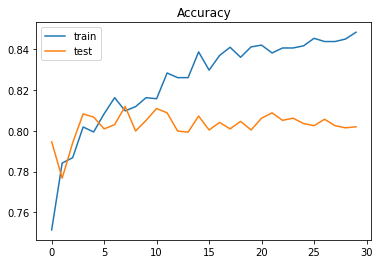

In [43]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [46]:
# Predictions
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)
# Creating submission file 
submission = pd.DataFrame({'id' : df_test['id'], 'target' : predictions})
submission.to_csv('./data/lstm_lr_submission.csv', index=False)

submission.head()

102/102 [==============================] - 1s 3ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


### Try multiple layers of LSTM

With learning rate schedule, the accuracy got improved a bit, let's try deeper architecture with one more layer of LSTM.


In [73]:
# Long Short Term Memory network.

# We need sequential model to process sequence of text data
model=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model.add(embedding)
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=32, activation='relu'))

# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 20, 100)           1492800   
                                                                 
 lstm_40 (LSTM)              (None, 20, 128)           117248    
                                                                 
 dropout_31 (Dropout)        (None, 20, 128)           0         
                                                                 
 lstm_41 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_32 (Dropout)        (None, 64)                0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 32)              

In [74]:
# Define learning rate schedule
def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

lrate = LearningRateScheduler(step_decay)

# train model with learning rate schedule
history=model.fit(X_train,y_train,batch_size=32,epochs=10,validation_data=(X_test,y_test),verbose=2,callbacks=[lrate])

Epoch 1/10
179/179 - 10s - loss: 0.6204 - accuracy: 0.6760 - val_loss: 0.6117 - val_accuracy: 0.6864 - lr: 0.0100 - 10s/epoch - 57ms/step
Epoch 2/10
179/179 - 5s - loss: 0.6854 - accuracy: 0.5675 - val_loss: 0.6802 - val_accuracy: 0.5814 - lr: 0.0100 - 5s/epoch - 29ms/step
Epoch 3/10
179/179 - 5s - loss: 0.6818 - accuracy: 0.5689 - val_loss: 0.6446 - val_accuracy: 0.6964 - lr: 0.0100 - 5s/epoch - 30ms/step
Epoch 4/10
179/179 - 5s - loss: 0.5690 - accuracy: 0.7290 - val_loss: 0.4912 - val_accuracy: 0.7820 - lr: 0.0100 - 5s/epoch - 30ms/step
Epoch 5/10
179/179 - 5s - loss: 0.4577 - accuracy: 0.8028 - val_loss: 0.4659 - val_accuracy: 0.7925 - lr: 0.0050 - 5s/epoch - 30ms/step
Epoch 6/10
179/179 - 5s - loss: 0.4196 - accuracy: 0.8233 - val_loss: 0.4756 - val_accuracy: 0.7973 - lr: 0.0050 - 5s/epoch - 30ms/step
Epoch 7/10
179/179 - 5s - loss: 0.3874 - accuracy: 0.8371 - val_loss: 0.4907 - val_accuracy: 0.7962 - lr: 0.0050 - 5s/epoch - 30ms/step
Epoch 8/10
179/179 - 5s - loss: 0.3502 - accur

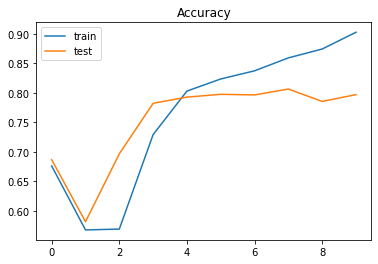

In [75]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [76]:
# Predictions
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)
# Creating submission file 
submission = pd.DataFrame({'id' : df_test['id'], 'target' : predictions})
submission.to_csv('./data/multi_lstm_lr_submission.csv', index=False)

submission.head()

102/102 [==============================] - 2s 10ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


______ 
# Result

Here are the scores received after submitting result to Kaggle. 


| submission file              | Architecture Detail                              | Score       |
|------------------------------|--------------------------------------------------|-------------|
| multi_lstm_lr_submission.csv |  2 layers LSTM with learning rate   schedule     | 0.78271     |
| lstm_lr_submission.csv       |  LSTM with learning rate schedule   (corrected)  | **0.80324** |
| lstm_lr_submission.csv       |  LSTM with learning rate schedule   (wrong file) | 0.77965     |
| gru_submission_1.csv         | RNN with one layer GRU                           | 0.77965     |
| lstm_submission_1.csv        | RNN with one layer LSTM                          | 0.79436     |


As we can see from the result, LSTM performed slightly better than GRU in this practice (accuracy score 0.79436 vs 0.77965).

After adding learning rate schedule to LSTM model, the score improved from 0.79436 to 0.80324, as it allows model to escape local minima or plateaus in the loss landscape. 
('LSTM with learning rate schedule   (wrong file)' is the case I upload the result file of GRU model by mistake, the score is same as that of  gru_submission_1.csv.)

Then I tried more deeper architecture with 2 layers LSTM, but it seems there is significant overfitting issue, the score got decreased (0.78271).

So the **next step** is to solve the overfitting issue, we can apply more dropout layers to the model. 



Snapshot from Kaggle for reference

![alt text](rnn_kaggle_score.png "Solution Score")